In [1]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import ShuffleSplit
import pickle

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
#device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

import contrastive_functions
sns.set_style('white')

2023-03-31 22:44:11.515198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 22:44:12.440386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ntolley/.openmpi/lib
2023-03-31 22:44:12.440509: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-31 22:44:12.509526: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-31 22:44:13.97

numprocs=1


In [2]:
# read python dict back from the file
data_file = open('../data/SPK20220308/neuron_num_results/neuron_sort_results_alternate(2).pkl', 'rb')

num_neuron_dict = pickle.load(data_file)
data_file.close()

In [3]:
num_neuron_dict.keys()

dict_keys(['num_fold', 'fold_0', 'fold_1', 'fold_2', 'fold_3'])

In [4]:
num_fold = num_neuron_dict['num_fold']

task_res = list()
notask_res = list()
for fold_idx in range(num_fold):
    num_neuron_list = num_neuron_dict[f'fold_{fold_idx}']['num_neuron_list']
    task_test_corr = list()
    notask_test_corr = list()
    for num_neurons in num_neuron_list:
        # res_dict = num_neuron_dict[f'repeat_{repeat_idx}'][f'num_neuron_{num_neurons}']
        res_dict = num_neuron_dict[f'fold_{fold_idx}'][f'num_neuron_{num_neurons}']
        task_test_corr.append(np.stack(res_dict['rnn']['task']['test_corr']))
        notask_test_corr.append(np.stack(res_dict['rnn']['notask']['test_corr']))

    task_res.append(np.stack(task_test_corr))
    notask_res.append(np.stack(notask_test_corr))

task_res = np.stack(task_res)
notask_res = np.stack(notask_res)


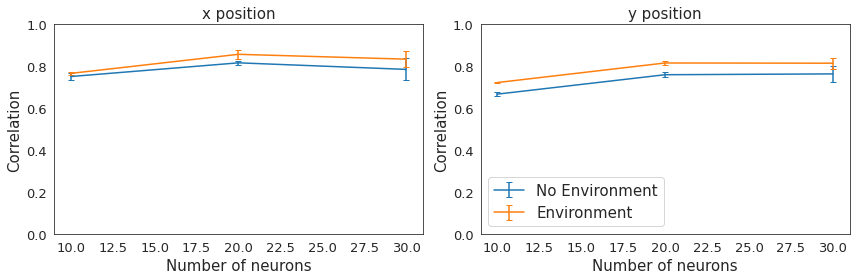

In [5]:
labelsize=15
ticksize=13
task_mean = np.mean(task_res, axis=0)
task_std = np.std(task_res,  axis=0)

notask_mean = np.mean(notask_res, axis=0)
notask_std = np.std(notask_res,  axis=0)

titles=['x position', 'y position']
plt.figure(figsize=(12,4))
for plot_idx in range(2):
    plt.subplot(1,2,plot_idx+1)
    plt.errorbar(x=num_neuron_list, y=notask_mean[:,plot_idx], yerr=notask_std[:,plot_idx], capsize=3, label='No Environment')
    plt.errorbar(x=num_neuron_list, y=task_mean[:,plot_idx], yerr=task_std[:,plot_idx], capsize=3, label='Environment')

    plt.tight_layout()
    plt.ylim(0.0,1)
    plt.title(titles[plot_idx], fontsize=labelsize)
    plt.xlabel('Number of neurons', fontsize=labelsize)
    plt.ylabel('Correlation', fontsize=labelsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.tight_layout()

plt.legend(fontsize=labelsize)
# plt.savefig('neuron_sort_curve.svg')

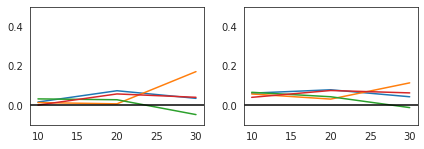

In [6]:
plt.figure(figsize=(6,6))
for plot_idx in range(2):
    plt.subplot(3,2,plot_idx+1)
    for repeat_idx in range(num_fold):

        corr_diff = task_res[repeat_idx, :, plot_idx] - notask_res[repeat_idx, :, plot_idx]
    
        plt.plot(num_neuron_list, corr_diff)

    plt.tight_layout()
    plt.axhline(y=0, color='k')
    plt.ylim(-0.1, 0.5)

In [7]:
neural_offset = 10 # try 50-150 ms offset
window_size = 70
label_col = 'layout'

noise_fold = 1
data_dict = contrastive_functions.get_marker_decode_dataframes(noise_fold = noise_fold)
wrist_df = data_dict['wrist_df']
task_neural_df = data_dict['task_neural_df']
notask_neural_df = data_dict['notask_neural_df']
metadata = data_dict['metadata']
cv_dict = data_dict['cv_dict']

neuron_list = notask_neural_df['unit'].unique()

/home/ntolley/Donoghue_Lab/ncm_2023/notebooks/../code/contrastive_functions.py:332: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/ntolley/Donoghue_Lab/ncm_2023/notebooks/../code/contrastive_functions.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/ntolley/Donoghue_Lab/ncm_2023/notebooks/../code/contrastive_functions.py:332: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [14]:
data_arrays, generators = contrastive_functions.make_generators(
    wrist_df, notask_neural_df, neural_offset, cv_dict, metadata, exclude_neural=None,
    window_size=window_size, flip_outputs=True, batch_size=1000, label_col='layout')

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

test_labels = testing_set[:][2].detach().cpu().numpy()

: 

: 

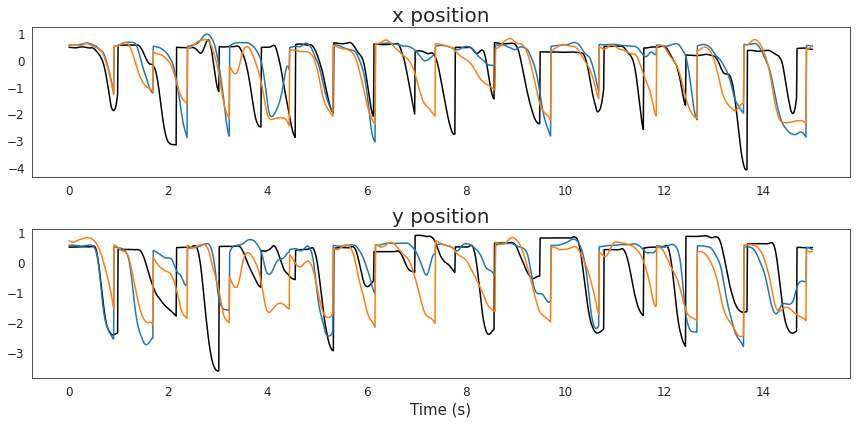

In [11]:
bounds = list(range(0,1500))
# bounds = list(range(500,1500))

x_times = np.array(bounds) / 100 # Sampling rate=100 Hz
labelsize=15
titlesize=20
ticksize=12

fold_name = f'fold_{noise_fold}'
num_neuron_name = 'num_neuron_30'

plt.figure(figsize=(12,6))
for mrk_idx in range(2):
    plt.subplot(2,1,mrk_idx+1)
    plt.plot(x_times, y_test_data[bounds,mrk_idx], color='k')
    plt.plot(x_times, num_neuron_dict[fold_name][num_neuron_name]['rnn']['notask']['test_pred'][bounds,mrk_idx])
    plt.plot(x_times, num_neuron_dict[fold_name][num_neuron_name]['rnn']['task']['test_pred'][bounds,mrk_idx])
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.title(titles[mrk_idx], fontsize=titlesize)

plt.xlabel('Time (s)', fontsize=labelsize)
plt.tight_layout()
# plt.savefig('predicted_trajectory.svg')


ValueError: operands could not be broadcast together with shapes (10238,) (4915,) 

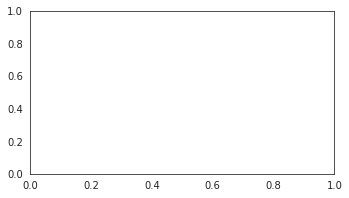

In [12]:
labelsize=15
ticksize=12

bins = np.linspace(-0.1, 2, 30)
plt.figure(figsize=(12,3))
for mrk_idx in range(2):
    plt.subplot(1,2,mrk_idx+1)

    notask_mse = np.abs(num_neuron_dict[fold_name][num_neuron_name]['rnn']['notask']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])
    task_mse = np.abs(num_neuron_dict[fold_name][num_neuron_name]['rnn']['task']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])

    # notask_mse = np.square(num_neuron_dict[fold_name][num_neuron_name]['rnn']['notask']['test_pred'][bounds,mrk_idx] - y_test_data[bounds,mrk_idx])
    # task_mse = np.square(num_neuron_dict[fold_name][num_neuron_name]['rnn']['task']['test_pred'][bounds,mrk_idx] - y_test_data[bounds,mrk_idx])
    plt.hist(notask_mse, bins=bins, alpha=0.5, density=True)
    plt.hist(task_mse, bins=bins, alpha=0.5, density=True)

    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.title(titles[mrk_idx], fontsize=labelsize)
    
    plt.xlabel('Error', fontsize=labelsize)
plt.tight_layout()
# plt.savefig('mse_histogram.svg')
